### Install Packages and Import Dataset

In this notebook, we’ll be working with a data set of 932 real estate transactions in Sacramento, California. This dataset contains several features regarding property details, including location, size, type, and price..

Each row in the dataset represents a listing, with various property details:

- **City:** The city where the property is located.
- **Zip:** The postal code for the property’s location.
- **Beds:** The number of bedrooms in the property.
- **Baths:** The number of bathrooms in the property.
- **Sqft:** The square footage of the property.
- **Type:** The type of property (e.g., Residential).
- **Latitude:** The latitude coordinate of the property.
- **Longitude:** The longitude coordinate of the property.

The target column is **Price**, which we will try to predict based on the other features in the dataset.

This dataset was obtained from [spatialkey](https://support.spatialkey.com/spatialkey-sample-csv-data/)

In [1]:
# import os
# os.environ["LOKY_MAX_CPU_COUNT"] = "12"  # Replace 12 with the desired number of cores


In [2]:
# Set random_state as a variable for consistency
random_state_value = 42


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error


## Our question: **Can we use the size of a house in the Sacramento, CA area to predict its sale price?**

In [4]:
# Output dataframes instead of arrays
set_config(transform_output="pandas")

sacramento = pd.read_csv("dataset/sacramento.csv")
sacramento


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,1 KENNELFORD CIR,SACRAMENTO,95823,CA,3,2,1144,Residential,Mon May 19 00:00:00 EDT 2008,200345,38.464520,-121.427606
1,10 SEA FOAM CT,SACRAMENTO,95831,CA,3,3,2052,Residential,Wed May 21 00:00:00 EDT 2008,415000,38.487885,-121.545947
2,100 CHELSEA CT,FOLSOM,95630,CA,3,2,1905,Residential,Mon May 19 00:00:00 EDT 2008,500000,38.694350,-121.177259
3,100 REBECCA WAY,FOLSOM,95630,CA,3,2,2185,Residential,Wed May 21 00:00:00 EDT 2008,344250,38.684790,-121.149199
4,100 TOURMALINE CIR,SACRAMENTO,95834,CA,5,3,3076,Residential,Mon May 19 00:00:00 EDT 2008,240000,38.634370,-121.510779
...,...,...,...,...,...,...,...,...,...,...,...,...
809,9880 IZILDA CT,SACRAMENTO,95829,CA,5,4,3863,Residential,Fri May 16 00:00:00 EDT 2008,598695,38.453260,-121.325730
810,993 MANTON CT,GALT,95632,CA,4,3,2307,Residential,Tue May 20 00:00:00 EDT 2008,300000,38.272942,-121.289148
811,9937 BURLINE ST,SACRAMENTO,95827,CA,3,2,1092,Residential,Fri May 16 00:00:00 EDT 2008,150000,38.559641,-121.323160
812,9949 NESTLING CIR,ELK GROVE,95757,CA,3,2,1543,Residential,Fri May 16 00:00:00 EDT 2008,275000,38.397455,-121.468391


This question guides our initial exploration: and after looking at the data, we can see that the columns in the data that we are interested in are 
- sq__ft (house size, in livable square feet)
-  price (house sale price, in US dollars (USD)). 

### Visualizing the Data

Now, let’s create a scatter plot to visualize the relationship between the predictor variable (**house size**) on the x-axis, and we place the response variable that we want to predict (**sale price**) on the y-axis.

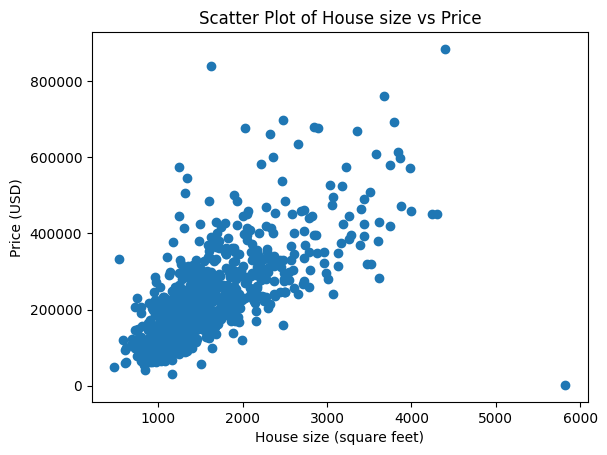

In [5]:
# Plot
plt.scatter(sacramento["sq__ft"], sacramento['price'])

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House size vs Price')
plt.show()


We can see that in Sacramento, CA, larger houses tend to have higher sale prices. This means we might be able to predict the sale price of a house we haven't sold yet based on its size. 

> **Note**:
> It's important to remember that we're not saying a bigger house **causes** a higher price; we're just observing that larger houses generally sell for more, so size can help us estimate the price.

### K-nearest neighbors regression

KNN regression is like K-Nearest Neighbors, but instead of predicting a category, it predicts a number. It looks at the closest `k` data points and then takes the average of their values to make the prediction. For example, if you want to predict a house price, KNN regression will look at the prices of the closest `k` houses and use their average as the predicted price.

Let's start with a small sample of the data to understand how K-nearest neighbors (KNN) works for regression. By using this small subset, we can illustrate the basics of KNN regression and how it predicts house sale prices before building and evaluating a full model.

To take a small random sample of size 30, we’ll use the `sample` method on the sacramento data frame, specifying that we want to select n=30 rows.

In [6]:
#set seed for reproducibility
#np.random.seed(10)
# Split the data
small_sacramento = sacramento.sample(n=30)
small_sacramento


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
329,4240 WINJE DR,ANTELOPE,95843,CA,4,2,2504,Residential,Fri May 16 00:00:00 EDT 2008,246750,38.708840,-121.359559
394,500 WINCHESTER CT,ROSEVILLE,95661,CA,3,2,2274,Residential,Mon May 19 00:00:00 EDT 2008,470000,38.739880,-121.248929
358,4631 11TH AVE,SACRAMENTO,95820,CA,2,1,1321,Residential,Tue May 20 00:00:00 EDT 2008,161829,38.541965,-121.452132
519,63 ANGEL ISLAND CIR,SACRAMENTO,95831,CA,4,2,2169,Residential,Fri May 16 00:00:00 EDT 2008,311518,38.490408,-121.547664
273,3692 PAYNE WAY,NORTH HIGHLANDS,95660,CA,3,1,957,Residential,Tue May 20 00:00:00 EDT 2008,129000,38.666540,-121.378298
174,2460 EL ROCCO WAY,RANCHO CORDOVA,95670,CA,3,2,1671,Residential,Tue May 20 00:00:00 EDT 2008,175000,38.591477,-121.315340
302,4004 CRESTA WAY,SACRAMENTO,95864,CA,3,3,2325,Residential,Wed May 21 00:00:00 EDT 2008,660000,38.591618,-121.370626
285,3820 NATOMA WAY,SACRAMENTO,95838,CA,4,2,1656,Residential,Wed May 21 00:00:00 EDT 2008,166357,38.636748,-121.422159
458,5706 GREENACRES WAY,ORANGEVALE,95662,CA,3,2,1176,Residential,Tue May 20 00:00:00 EDT 2008,250000,38.669882,-121.213533
331,4250 ARDWELL WAY,SACRAMENTO,95823,CA,3,2,1089,Residential,Fri May 16 00:00:00 EDT 2008,95625,38.466938,-121.455631


To estimate the sale price of a 2,000 square-foot house in Sacramento when we don't have exact data for that size, we can use KNN.

1. **Find Similar Houses**: Identify houses in the dataset that are closest in size to 2,000 square feet. This involves calculating the distance between the 2,000 square-foot house and the sizes of other houses in the dataset.

2. **Select Neighbors**: Choose a small number of these closest houses (the "neighbors"). The number of neighbors is a parameter you can set for KNN.

3. **Average Price**: Calculate the average sale price of these neighbors. This average will give you an estimate of the price for the 2,000 square-foot house.

By using this approach, you can make an informed offer based on the sale prices of similar houses in the dataset, even though you don’t have an exact match for the 2,000 square-foot size.

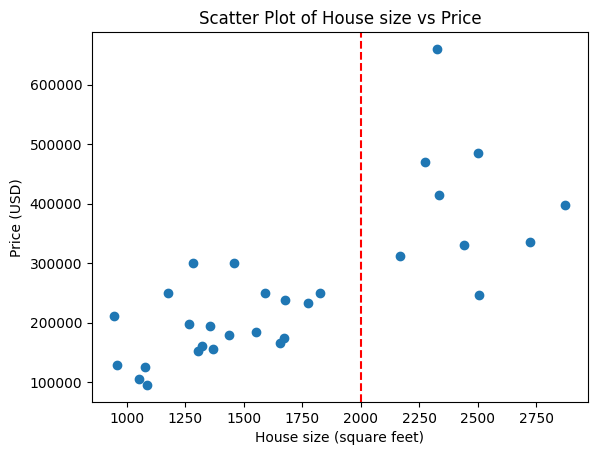

In [7]:
# Plot
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'])

# Add a vertical line at 2,000 square feet
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House size vs Price')

plt.show()


We will employ the same idea as our prior notebooks, and use the neighboring points to the new point of interest to predict what its sale price might be. 

For the example here we find and label the 5 nearest neighbors to our observation of a house that is 2,000 square feet.

In [8]:
# Calculate the absolute difference between 2000 and the square footage of each house
small_sacramento["dist"] = (2000 - small_sacramento["sq__ft"]).abs()

# Find the 5 rows with the smallest distances (closest to 2000 square feet)
nearest_neighbors = small_sacramento.nsmallest(5, "dist")

# Display the 5 nearest neighbors
nearest_neighbors


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,dist
519,63 ANGEL ISLAND CIR,SACRAMENTO,95831,CA,4,2,2169,Residential,Fri May 16 00:00:00 EDT 2008,311518,38.490408,-121.547664,169
257,3450 WHITNOR CT,SACRAMENTO,95821,CA,3,2,1828,Residential,Fri May 16 00:00:00 EDT 2008,250000,38.627698,-121.369698,172
424,5340 BIRK WAY,SACRAMENTO,95835,CA,3,2,1776,Residential,Tue May 20 00:00:00 EDT 2008,234000,38.672495,-121.515251,224
394,500 WINCHESTER CT,ROSEVILLE,95661,CA,3,2,2274,Residential,Mon May 19 00:00:00 EDT 2008,470000,38.739880,-121.248929,274
242,3301 PARK DR Unit 1914,SACRAMENTO,95835,CA,3,2,1678,Condo,Mon May 19 00:00:00 EDT 2008,238000,38.665296,-121.531993,322


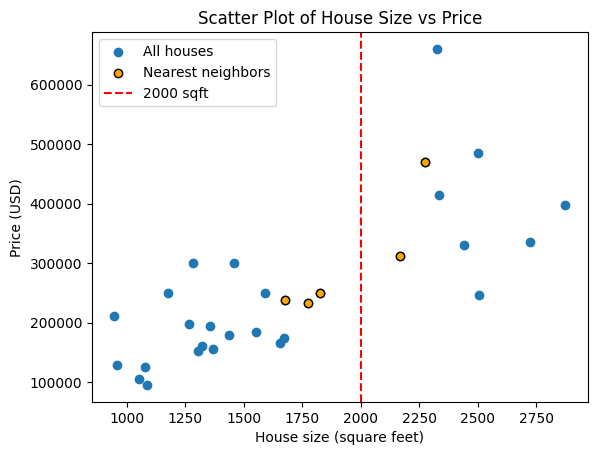

In [9]:
# Scatter plot
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'], label='All houses')

# Plot nearest neighbors in orange
plt.scatter(nearest_neighbors["sq__ft"], nearest_neighbors['price'], color='orange', label='Nearest neighbors', edgecolor='black')

# Add a vertical line at 2,000 square feet
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')

# Add labels, title, and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House Size vs Price')
plt.legend()


We can then take the mean (or average) of these 5 values as our predicted value,

In [10]:
prediction = nearest_neighbors["price"].mean()
prediction


np.float64(300703.6)

Similar to KNN classification, we have some remaining steps. which $K$ do we choose, and is our model any good at making predictions?

### Training, evaluating, and tuning the model

Step 1. Split the dataset into test and train

In [11]:
sacramento_train, sacramento_test = train_test_split(
    sacramento, train_size=0.75, random_state=random_state_value
)


In [12]:
sacramento_train.shape


(610, 12)

In [13]:
sacramento_test.shape


(204, 12)

Step 2. Cross-validation

In KNN regression, to evaluate how well the model predicts the response variable, we use root mean square prediction error (RMSPE). The formula for calculating RMSPE is:

$$
 \text{RMSPE} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

where:
- $ y_i $ is the true value of the response variable,
- $ \hat{y}_i $ is the predicted value from the model,
- $ n $ is the number of observations.

RMSPE measures how much our predictions deviate from the actual values. It gives us an idea of how close our predictions are to the real outcomes.

Here is the above mathematical notation in python:

In [14]:
import math

def rmspe(y_true, y_pred):
    """
    Calculate Root Mean Squared Prediction Error (RMSPE) # or also called RMSE: Root Mean Squared Error
    
    Parameters:
    y_true: list-like, actual values
    y_pred: list-like, predicted values
    
    Returns:
    float: RMSPE value
    """
    n = len(y_true)
    squared_errors = []

    for i in range(n):
        error = y_true[i] - y_pred[i]
        squared_errors.append(error ** 2)

    mean_squared_error = sum(squared_errors) / n

    # Calculate the square root of the mean squared error
    rmspe_value = math.sqrt(mean_squared_error)
    
    return rmspe_value


### Let's Begin KNN Regressor Training:

Let's see if there is any correlation between square footage and price.

In [15]:
print(sacramento_train[["sq__ft", "price"]].isnull().sum())


sq__ft    0
price     0
dtype: int64


In [16]:
print(sacramento_train.dtypes)


street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object


In [17]:
# print(list(param_grid["n_neighbors"]))


In [18]:
# print(results.head())


In [19]:
# print(results["mean_test_score"].isnull().sum())


In [20]:
# Step 1: Split training data into X (predictor) and Y (response)
X_train = sacramento_train[["sq__ft"]]
y_train = sacramento_train["price"]

# Step 2: Initialize K-NN regressor
knn_regressor = KNeighborsRegressor()

# Step 3: Define parameter grid for GridSearchCV
param_grid = {
    "n_neighbors": range(1, 201, 3),        # But wait...? What is this?
}

# Step 4: Initialize and fit GridSearchCV
sacr_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

sacr_gridsearch.fit(X_train, y_train)

# Step 5: Retrieve and format results
results = pd.DataFrame(sacr_gridsearch.cv_results_)     # After fitting the model, we extract the cross-validation results using `cv_results_`. This output includes various metrics and parameters tested during the cross-validation process.
results = (
    results[[
        "param_n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_n_neighbors": "n_neighbors"})
) # we specify the scoring metric as "neg_root_mean_squared_error" to evaluate the model performance based on RMSPE.

print(results)


    n_neighbors  mean_test_score
0             1   -112475.562546
1             4    -89014.823175
2             7    -85393.466480
3            10    -84276.675940
4            13    -84443.613862
..          ...              ...
62          187    -90242.148105
63          190    -90514.260612
64          193    -90725.395610
65          196    -90875.165190
66          199    -91112.560810

[67 rows x 2 columns]


>
> ##### But Wait...?
>
> *"Why are they using 1-200? How do they know 200 is enough?"*
>   - They don't! That's just an intuition, they could've done 20. They are testing values from 1 to 200 because different datasets and problems might require different optimal values for n_neighbors.
>
> *"Well why are they checking every 3 steps? Why not all of them?"*
>   - The step size of 3 is used to reduce the number of computations, ensuring a balance between exploring a wide range of values and not taking too long by testing every possible value between 1 and 200.
>

Next, we can run cross-validation by calling the fit method on our GridSearchCV object (sacr_gridsearch).

>
> #### Note:
>
> The use of double brackets sacramento_train[["sqft"]] to ensure the input features are in a DataFrame format. 
> This is important because scikit-learn often works better with DataFrames rather than Series for input features. 
>
 
Lastly, we extract relevant columns (e.g., mean test scores and parameter values) based on the 5-fold cross-validation.

In [21]:
results


,n_neighbors,mean_test_score
0,1,-112475.562546
1,4,-89014.823175
2,7,-85393.466480
3,10,-84276.675940
4,13,-84443.613862
...,...,...
62,187,-90242.148105
63,190,-90514.260612
64,193,-90725.395610
65,196,-90875.165190


In the `results` DataFrame, the `n_neighbors` column shows the values of `n_neighbors`, and the `mean_test_score` column displays the RMSPE values estimated via cross-validation. However, RMSPE is always be nonnegative because it measures **how far off the model’s predictions are from the actual values**—the difference, like a distance, can’t be negative.

Scikit-learn was built to always try to **maximize** scores. Since RMSPE is a metric where **lower is better**, it automatically flips it to a negative value (that’s why there’s a `"neg_"` prefix). This lets Scikit-learn treat it like a score to maximize, even though we are really trying to minimize the error. To get the actual RMSPE values, we need to convert these negative values back to positive by taking their absolute values.

In [22]:
results["mean_test_score"] = -results["mean_test_score"]
results


,n_neighbors,mean_test_score
0,1,112475.562546
1,4,89014.823175
2,7,85393.466480
3,10,84276.675940
4,13,84443.613862
...,...,...
62,187,90242.148105
63,190,90514.260612
64,193,90725.395610
65,196,90875.165190


In the updated `results` DataFrame, the `mean_test_score` now correctly reflects the RMSPE values for different numbers of neighbors. 

We can visualize how RMSPE changes with different numbers of neighbors. By finding the minimum RMSPE, we can determine the best number of neighbors for our model. In this case, the lowest RMSPE occurs when the number of neighbors is 25.

In [23]:
results.nsmallest(1, 'mean_test_score')


,n_neighbors,mean_test_score
8,25,82522.870892


In [24]:
sacr_gridsearch.best_params_


{'n_neighbors': 25}

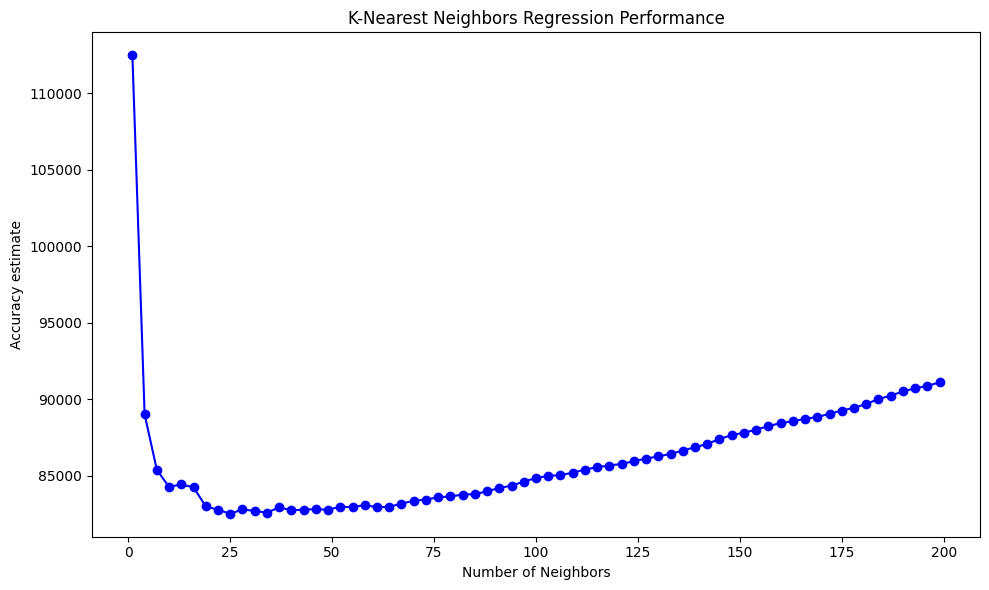

In [25]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(results['n_neighbors'], results['mean_test_score'], '-o', color='blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout()
plt.show()


### Model Evaluation

To evaluate how well our model predicts unseen data, we'll check its RMSPE on the test set. First, we need to retrain the K-NN regression model using 25 neighbors on the full training data. Scikit-learn handles this automatically when using `GridSearchCV`. To make predictions, we use the `predict` method from the fitted `GridSearchCV` object. We then calculate the RMSPE by computing the mean squared error with `mean_squared_error` and taking the square root. We use this method instead of the `score` method because `KNeighborsRegressor` uses a different default metric than RMSPE.

In [26]:
# Make predictions on the test set
sacramento_test["predicted"] = sacr_gridsearch.predict(sacramento_test[["sq__ft"]])

# Calculate RMSPE
rmspe = mean_squared_error(
    y_true=sacramento_test["price"],
    y_pred=sacramento_test["predicted"]
)**0.5

rmspe


np.float64(93573.27378694214)

Our final model’s test error as assessed by RMSPE is $93,634

> **Note:**
>
> The RMSPE is in the same units as the response variable, so for new observations, we expect prediction errors to be around $93,634. In this case, it’s not negligible and could significantly impact a home buyer's budget, influencing their decision to make an offer on a house.

We can visualize the predictions of our final model across various house sizes in Sacramento. 

We can overlay a prediction line on a scatter plot of the original housing price data to qualitatively assess how well the model fits the data. 

c:\Users\AC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


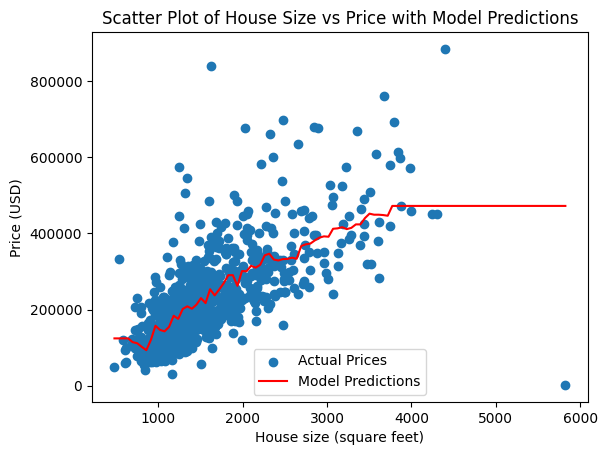

In [27]:
# Generate a range of house sizes for prediction
sizes = np.linspace(sacramento["sq__ft"].min(), sacramento["sq__ft"].max(), 100).reshape(-1, 1)

# Predict house prices for these sizes using the best model from GridSearchCV
predicted_prices = sacr_gridsearch.predict(sizes)

# Plot the original data
plt.scatter(sacramento["sq__ft"], sacramento["price"], label="Actual Prices")

# Plot the model predictions as a line
plt.plot(sizes, predicted_prices, color='red', label="Model Predictions")

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel("Price (USD)")
plt.title("Scatter Plot of House Size vs Price with Model Predictions")
plt.legend()
plt.show();


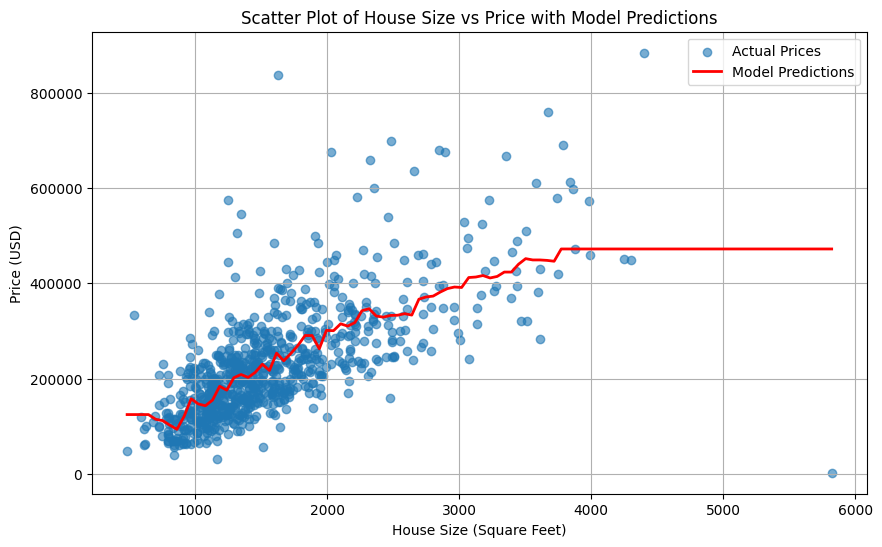

In [28]:
# Generate a range of house sizes for prediction
sizes = np.linspace(sacramento["sq__ft"].min(), sacramento["sq__ft"].max(), 100).reshape(-1, 1)

# Convert sizes into a DataFrame with the same column name as the training data
sizes_df = pd.DataFrame(sizes, columns=["sq__ft"])

# Predict house prices for these sizes using the best model from GridSearchCV
predicted_prices = sacr_gridsearch.predict(sizes_df)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(sacramento["sq__ft"], sacramento["price"], alpha=0.6, label="Actual Prices")

# Plot the model predictions as a line
plt.plot(sizes, predicted_prices, color='red', linewidth=2, label="Model Predictions")

# Add labels and legend
plt.xlabel("House Size (Square Feet)")
plt.ylabel("Price (USD)")
plt.title("Scatter Plot of House Size vs Price with Model Predictions")
plt.legend()
plt.grid()
plt.show()


Don't worry about the details of this plot. This is simply depicting the predicted values of house price (red line) for the final KNN regression model.



### Conclusion

In this notebook, we worked through several steps to predict housing prices using square feet using a data set of 932 real estate transactions in Sacramento, California. Here's a summary of what we covered:

1. **K-Nearest Neighbors Regression (KNN):** We implemented the KNN regression and evaluated its performance on a test dataset.

2. **Cross-Validation:** We used cross-validation to determine the optimal $k$ value for our model.


We hope this notebook has provided a practical understanding of data regression, model evaluation, and the application of machine learning algorithms like KNN. Feel free to experiment further with the dataset or the code to enhance your learning!

In [29]:
best_result = results.loc[results["mean_test_score"].idxmax()]
print(f"Best n_neighbors: {best_result['n_neighbors']}")
print(f"Best mean_test_score (RMSE): {-best_result['mean_test_score']:.2f}")


Best n_neighbors: 1.0
Best mean_test_score (RMSE): -112475.56


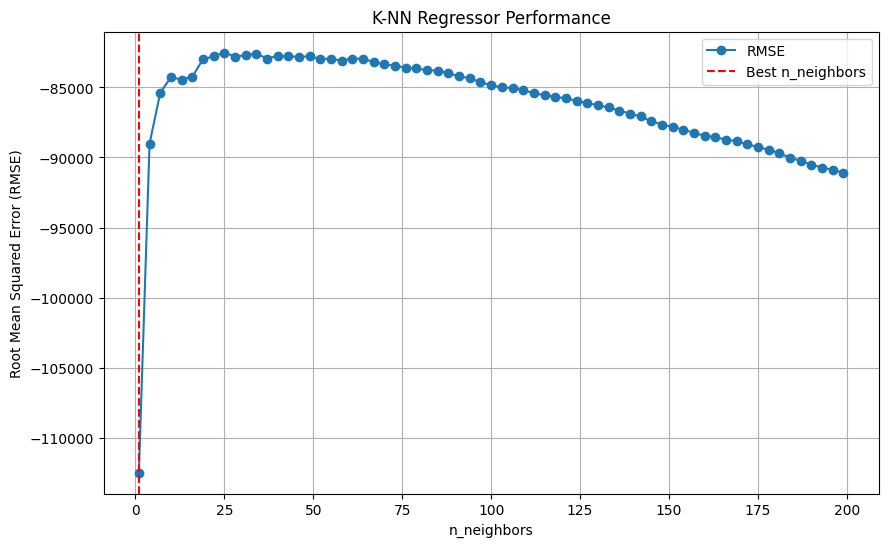

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results["n_neighbors"], -results["mean_test_score"], marker='o', label='RMSE')
plt.axvline(best_result["n_neighbors"], color='red', linestyle='--', label='Best n_neighbors')
plt.xlabel("n_neighbors")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("K-NN Regressor Performance")
plt.legend()
plt.grid()
plt.show()


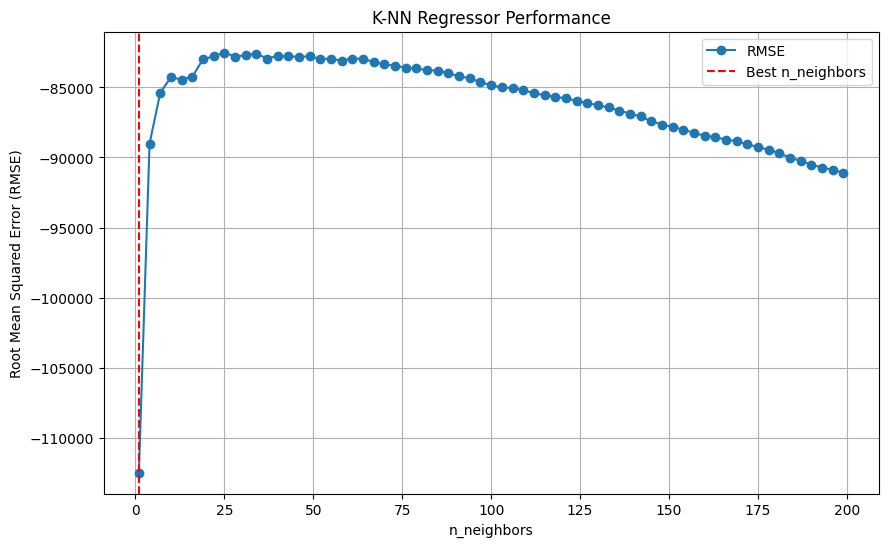

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results["n_neighbors"], -results["mean_test_score"], marker='o', label='RMSE')
plt.axvline(best_result["n_neighbors"], color='red', linestyle='--', label='Best n_neighbors')
plt.xlabel("n_neighbors")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("K-NN Regressor Performance")
plt.legend()
plt.grid()
plt.show()


In [32]:
baseline_rmse = ((y_train - y_train.mean())**2).mean()**0.5
print(f"Baseline RMSE (mean predictor): {baseline_rmse:.2f}")


Baseline RMSE (mean predictor): 117358.39


In [33]:
from sklearn.metrics import mean_squared_error

best_knn = KNeighborsRegressor(n_neighbors=int(best_result["n_neighbors"]))
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(sacramento_test[["sq__ft"]])
test_rmse = mean_squared_error(sacramento_test["price"], y_pred, squared=False)
print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 129455.68


c:\Users\AC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
# Fix TypeError in parameter grid
best_n_neighbors = int(best_result["n_neighbors"])
param_grid = {"n_neighbors": range(max(1, best_n_neighbors - 10), best_n_neighbors + 10, 1)}

# Redefine and fit the model with the best number of neighbors
best_knn = KNeighborsRegressor(n_neighbors=best_n_neighbors)
best_knn.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = best_knn.predict(sacramento_test[["sq__ft"]])
test_rmse = mean_squared_error(sacramento_test["price"], y_pred, squared=False)  # Manual RMSE calculation
print(f"Test RMSE: {test_rmse:.2f}")

# Alternatively, if using sklearn >= 1.4
# from sklearn.metrics import root_mean_squared_error
# test_rmse = root_mean_squared_error(sacramento_test["price"], y_pred)
# print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 129455.68


c:\Users\AC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
sacr_gridsearch.best_params_


{'n_neighbors': 25}

Organized

               street        city    zip state  beds  baths  sq__ft  \
0    1 KENNELFORD CIR  SACRAMENTO  95823    CA     3      2    1144   
1      10 SEA FOAM CT  SACRAMENTO  95831    CA     3      3    2052   
2      100 CHELSEA CT      FOLSOM  95630    CA     3      2    1905   
3     100 REBECCA WAY      FOLSOM  95630    CA     3      2    2185   
4  100 TOURMALINE CIR  SACRAMENTO  95834    CA     5      3    3076   

          type                     sale_date   price   latitude   longitude  
0  Residential  Mon May 19 00:00:00 EDT 2008  200345  38.464520 -121.427606  
1  Residential  Wed May 21 00:00:00 EDT 2008  415000  38.487885 -121.545947  
2  Residential  Mon May 19 00:00:00 EDT 2008  500000  38.694350 -121.177259  
3  Residential  Wed May 21 00:00:00 EDT 2008  344250  38.684790 -121.149199  
4  Residential  Mon May 19 00:00:00 EDT 2008  240000  38.634370 -121.510779  


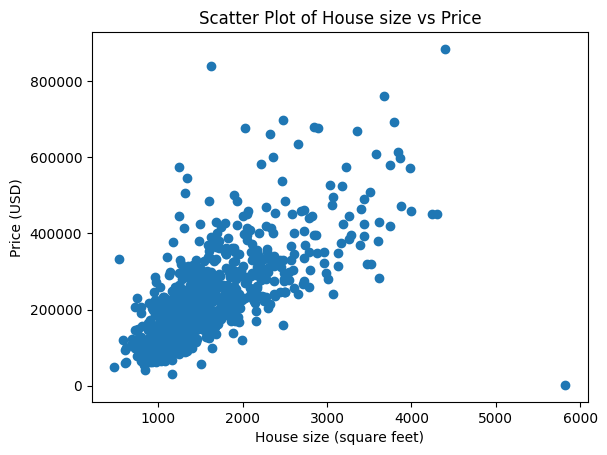

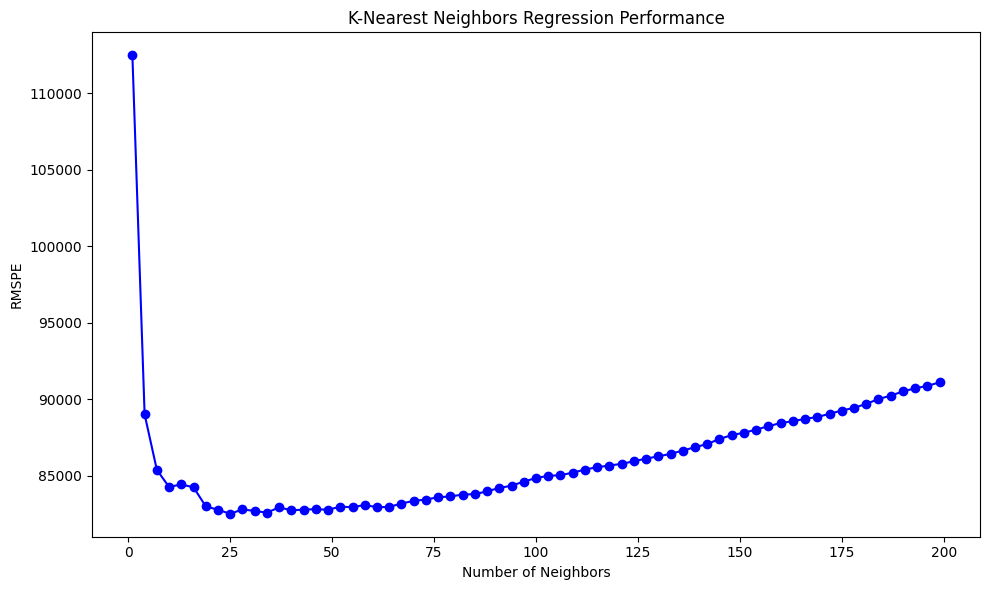

Test RMSPE: 93573.27


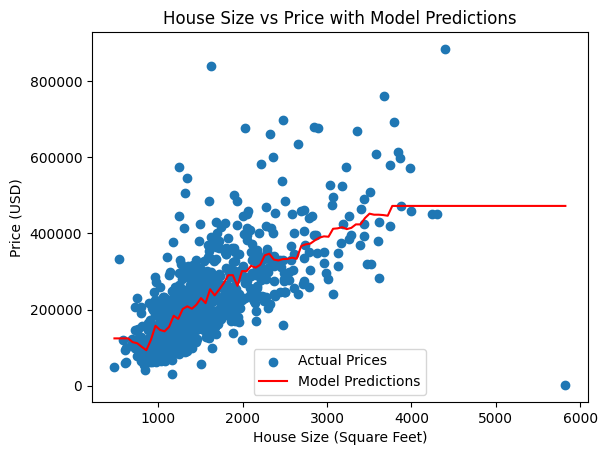

Optimal n_neighbors: 25.0
RMSPE at optimal k: 82522.87


In [40]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import set_config

# Set random seed for reproducibility
random_state_value = 42

# Set output for DataFrame instead of arrays
set_config(transform_output="pandas")

# Load dataset (Assuming the dataset is stored locally at "dataset/sacramento.csv")
sacramento = pd.read_csv("dataset/sacramento.csv")

# Explore the dataset structure
print(sacramento.head())

# Visualize the relationship between house size and price
plt.scatter(sacramento["sq__ft"], sacramento['price'])
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House size vs Price')
plt.show()

# Split data into training and testing sets (75% for training, 25% for testing)
sacramento_train, sacramento_test = train_test_split(sacramento, train_size=0.75, random_state=random_state_value)

# Prepare training data (predictor X and response y)
X_train = sacramento_train[["sq__ft"]]  # Ensure X_train is a DataFrame
y_train = sacramento_train["price"]

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor()

# Define parameter grid for GridSearchCV to tune 'n_neighbors'
param_grid = {
    "n_neighbors": range(1, 201, 3)  # Testing k values from 1 to 200 with step size 3
}

# Initialize GridSearchCV to perform cross-validation and tune parameters
sacr_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error"  # Using RMSPE (negative for maximization)
)

# Fit the model to the training data
sacr_gridsearch.fit(X_train, y_train)

# Extract results and adjust for RMSPE scoring (negative values)
results = pd.DataFrame(sacr_gridsearch.cv_results_)
results = results[["param_n_neighbors", "mean_test_score"]].rename(columns={"param_n_neighbors": "n_neighbors"})
results["mean_test_score"] = -results["mean_test_score"]  # Convert negative RMSPE to positive

# Visualize performance across different k values
plt.figure(figsize=(10, 6))
plt.plot(results['n_neighbors'], results['mean_test_score'], '-o', color='blue')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSPE')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout()
plt.show()

# Find the optimal number of neighbors (best k)
best_result = results.loc[results["mean_test_score"].idxmin()]
best_n_neighbors = best_result["n_neighbors"]

# Retrain model with the best k value
best_knn = KNeighborsRegressor(n_neighbors=int(best_n_neighbors))
best_knn.fit(X_train, y_train)

# Predict on the test set using the best model from GridSearchCV
X_test = sacramento_test[["sq__ft"]]  # Ensure X_test is a DataFrame with the correct column name
sacramento_test["predicted"] = best_knn.predict(X_test)  # Use best_knn instead of sacr_gridsearch.best_estimator_

# Calculate RMSPE on the test set
rmspe = mean_squared_error(
    y_true=sacramento_test["price"],
    y_pred=sacramento_test["predicted"]
)**0.5

# Output the test RMSPE value
print(f"Test RMSPE: {rmspe:.2f}")

# Generate predictions across a range of house sizes for visualization
sizes = np.linspace(sacramento["sq__ft"].min(), sacramento["sq__ft"].max(), 100).reshape(-1, 1)

# Ensure sizes is a DataFrame with the correct column name, and then predict
sizes_df = pd.DataFrame(sizes, columns=["sq__ft"])
predicted_prices = best_knn.predict(sizes_df)  # Ensure we use a DataFrame here

# Plot the model predictions alongside the original data
plt.scatter(sacramento["sq__ft"], sacramento["price"], label="Actual Prices")
plt.plot(sizes, predicted_prices, color='red', label="Model Predictions")
plt.xlabel("House Size (Square Feet)")
plt.ylabel("Price (USD)")
plt.title("House Size vs Price with Model Predictions")
plt.legend()
plt.show()

# Display the optimal number of neighbors and corresponding RMSPE
print(f"Optimal n_neighbors: {best_n_neighbors}")
print(f"RMSPE at optimal k: {best_result['mean_test_score']:.2f}")
